<a href="https://colab.research.google.com/github/hikaruyaku/for_work/blob/master/Membrane_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 膜分離モジュールのシミュレーター

## 作成の経緯
Excelのマクロで組んだらクソofクソの遅さなので，python で作成する．

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import minimize

## 使い方
下の記入フォームを記載した後，`Ctrl + F9`を押す．

In [43]:
#@title 記入フォーム
#@markdown 前提条件を記載してください．

#@markdown フィード流量=kg/h, 初期温度=℃, 操作圧力 = kPaA


膜の単位数 = 1000  #@param {type: "slider", min: 10, max: 1000}
膜本数 = 5000  #@param {type: "number"}
フィード流量 = 15000  #@param {type: "number"}
水の重量濃度 = 0.53  #@param {type: "number"}
初期温度 = 130  #@param {type: "number"}
操作圧力_kPaA =   0.1#@param {type: "number"}

#@markdown ---


## 前提条件

In [50]:
# 物性
## Antoine 定数
A_h2o = 7.07
B_h2o = 1657.46
C_h2o = 227.02
A_acoh = 6.42452
B_acoh = 1479.02
C_acoh = 216.81
## wilson の活量係数
Lambda_11 = 3351.51
Lambda_12 = 29.6876
## ガス透過係数
Q_h2o = 5e-6
Q_acoh = 1.25e-8
## 膜厚
sigma = 1e-5
## 分子量
mw_h2o = 18
mw_acoh = 60
## 顕熱[kJ/mol*K]
Cp_h2o = 0.0756
Cp_acoh = 0.1292
## 潜熱[kJ/mol]
h_h2o = 40.7
h_acoh = 24.4
## 活量係数
gamma_h2o = 0.0003037
gamma_acog = 0.22224

In [51]:
# 膜特性
ID = 0.012
L = 0.7
N = 膜本数
length = L/膜の単位数

# 膜の面積も出しちゃう
dA = 0.012*math.pi*length

## 関数

In [52]:
# Antoineでの蒸気圧の出す関数

def antoine_func(a,b,c,T):
  p_ast = 10 ** (a-b/(c+T))
  return p_ast

# dL1 を出す関数
def dl_1(Temp, x, yp):
  dl_1 = -Q_h2o / sigma * ( gamma_h2o * antoine_func(A_h2o,B_h2o,C_h2o,Temp) * x - 操作圧力_kPaA * yp ) * dA
  return dl_1
# dL2 を出す関数
def dl_2(Temp, x, yp):
  dl_2 = -Q_acoh / sigma * ( gamma_h2o * antoine_func(A_acoh,B_acoh,C_acoh,Temp)*(1-x) - 操作圧力_kPaA * (1-yp) ) * dA
  return dl_2

# 蒸気透過後の温度を出す関数
def temp_cal(l_h2o,l_acoh,v_h2o,v_acoh):
  delta_temp = (v_h2o * h_h2o + v_acoh * h_acoh)/1000/(l_h2o * Cp_h2o + l_acoh * Cp_acoh)
  return delta_temp

## 本計算
- 本計算は `for`文を用いた繰り返し計算を行う．
- また `for` 文内で，マテリアルバランスの式と膜透過の式の連立方程式を解く．

$$
\begin{eqnarray}
\frac{dL_1}{dA} &=& -\frac{Q_1}{\sigma}(\gamma_1 p_1^*x - p_1y_p)  \\
\frac{dL_2}{dA} &=& -\frac{Q_2}{\sigma}(\gamma_2 p_2^*(1-x) - p_1(1-y_p)) \\
(dL_1 + dL_2)  y_p &=& dL_1
\end{eqnarray}
$$

上記の3つの式を用いると

$$
[\frac{Q_1}{\sigma}((\gamma_1 p_1^*x - p_1y_p)dA+\frac{Q_2}{\sigma}(\gamma_2 p_2^*(1-x) - p_1(1-y_p))]dAy_p = \frac{Q_1}{\sigma}(\gamma_1 p_1^*x - p_1y_p)dA
$$

$y_p$に関する2次関数が出来る．  
これが0になるように収束計算を行う．

In [53]:
mass_frac_h2o = 水の重量濃度
feed = フィード流量

t_temp = 初期温度
# 組成を計算
l_h2o_temp = mass_frac_h2o * feed * 1000 / mw_h2o
l_acoh_temp = (1-mass_frac_h2o)*feed * 1000 / mw_acoh

results = [l_h2o_temp,l_acoh_temp,t_temp,0,0,0]

for i in range(膜の単位数):
  # 各温度での蒸気圧を推算
  p_1_ast_temp = antoine_func(A_h2o,B_h2o,C_h2o,t_temp) 
  p_2_ast_temp = antoine_func(A_acoh,B_acoh,C_acoh,t_temp)
  # 組成を計算
  x_temp = l_h2o_temp/(l_h2o_temp + l_acoh_temp)
  # 最小化するモデルの関数を作成
  def opt_target(yp):
    return ((yp * (dl_1(t_temp,x_temp,yp)+dl_2(t_temp,x_temp,yp)) - dl_1(t_temp,x_temp,yp))*10e+6)**2 # 2乗にすることで，最小値を0以上にする．
  # 制約条件を宣言
  def cons(yp):
    return (-yp+1)
  cons = ({'type':'ineq','fun':cons})
  # 最小化を実行
  cg = minimize(opt_target,x0=0.9,constraints=cons)
  # 実施したものからyp_predを抜出．
  yp_pred = cg.x[0]
  # 蒸気として透過した分を計算
  dl_1_temp = dl_1(t_temp,x_temp,yp_pred)
  dl_2_temp = dl_2(t_temp,x_temp,yp_pred)
  # 蒸気透過して液として残存した分を計算して x_temp を更新
  l_h2o_temp = l_h2o_temp - dl_1_temp
  l_acoh_temp = l_acoh_temp - dl_2_temp
  # 温度現状分を加味して t_temp を更新
  t_temp = t_temp - temp_cal(l_h2o_temp,l_acoh_temp,dl_1_temp,dl_2_temp)
  # 内容を格納
  results_temp = [l_h2o_temp,l_acoh_temp,t_temp,dl_1_temp,dl_2_temp,yp_pred]
  results = np.vstack([results, results_temp])

df = pd.DataFrame(results)
df.columns = ["L_H2O","L_AcOH","Temp.","V_H2O","V_AcOH","yp"]

In [54]:
df


,L_H2O,L_AcOH,Temp.,V_H2O,V_AcOH,yp
0,441666.666667,117500.0,130.0,0.000000e+00,0.000000e+00,0.0
1,441666.666666,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
2,441666.666666,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
3,441666.666665,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
4,441666.666665,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
...,...,...,...,...,...,...
996,441666.666196,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
997,441666.666196,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
998,441666.666195,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0
999,441666.666195,117500.0,130.0,4.724126e-07,-3.042005e-10,1.0


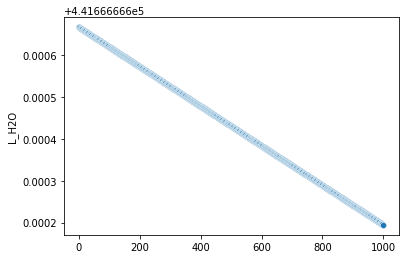

In [56]:
sns.scatterplot(x=range(1001),y=df.iloc[:,0])

In [41]:
print(df.index)

RangeIndex(start=0, stop=1001, step=1)
